In [11]:
import os
import random
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import DQNTradingAgent.dqn_agent as dqn_agent
from leverage_trading_env import TradingEnv, action2position
from custom_hyperparameters import hyperparams
import argparse
from data_downloader import read_binance_futures_data

parser = argparse.ArgumentParser()

parser.add_argument('--agent_num', type=int, default=1,
                    help='which agent to load')

parser.add_argument('--device_num', type=int, default=0,
                    help='cuda device num')

parser.add_argument('--fee', type=float, default=.001,
                    help='fee percentage')

parser.add_argument('--save_location', type=str, default=f"saves/test_visualization",
                    help='where to save?')
                    
parser.add_argument('--risk_aversion_multiplier', type=float, default=1.,
                        help='risk_aversion_level')

parser.add_argument('--load_file', type=str, default="saves/IQN_1d/IQN_leverage_1200.pth",
                    help='which to load to save?')

parser.add_argument('--data_path', type=str, default="binance_futures_1d_test.db",
                    help='where to load source data')

parser.add_argument('--symbol', type=str, default="BTCUSDT",
                    help='what symbol to read')

parser.add_argument('--timeframe', type=str, default="1h",
                    help='resample period. ex : 10m, 1h, 4h, 1d')

args = parser.parse_args([])




In [12]:

torch.cuda.manual_seed_all(7)
device = torch.device("cuda:{}".format(args.device_num))
dqn_agent.set_device(device)

save_interval  = 100
print_interval = 1

n_episodes   = 10
sample_len   = 250
obs_data_len = 192
step_len     = 1
risk_aversion_multiplier = 0.5 + args.risk_aversion_multiplier / 2
n_action_intervals = 5
init_budget = 10000

# torch.save(hyperparams, os.path.join(args.save_location, "hyperparams.pth"))
if not os.path.exists(args.save_location):
    os.makedirs(args.save_location)

df = read_binance_futures_data(args.data_path, args.symbol, args.timeframe)

/home/jeffrey/anaconda3/envs/gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

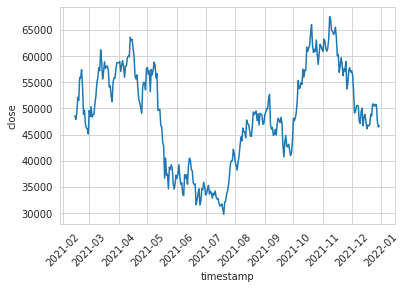

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
# basic visualization : price trend across the time
sns.lineplot(df.index, df.close)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)


In [14]:
env = TradingEnv(custom_args=args, env_id='leverage_trading_env', obs_data_len=obs_data_len, step_len=step_len,
                     sample_len=sample_len,
                     df=df, fee=0.001, initial_budget=init_budget, n_action_intervals=n_action_intervals,
                     deal_col_name='close', sell_at_end=True,
                     feature_names=['open', 'high', 'low', 'close', 'volume', ])
agent = dqn_agent.Agent(action_size=2 * n_action_intervals + 1, risk_averse_ratio=args.risk_aversion_multiplier, obs_len=obs_data_len,
                        num_features=env.observation_space[1], **hyperparams)

agent.qnetwork_local.load_state_dict(torch.load(args.load_file, map_location=device))
agent.qnetwork_local.to(device)
agent.qnetwork_local.eval()

QNetwork(
  (embedding): Linear(in_features=5, out_features=512, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (phi): NoisyLinear(in_features=1, out_features=512, bias=True, initial_sigma=0.5, factorized=True)
  (fc): NoisyLinear(in_features=512, out_features=64, bias=True, initial_sigma=0.5, factorized=True)
  (fc_q): NoisyLinear(in_features=64, out_features=11, b

In [22]:
state, info = env.reset()
score = 0.
actions = []
rewards = []
price_list = []

while True:
    action = int(agent.act(state, eps=0.))
    actions.append(action)
    next_state, reward, done, info  = env.step(action2position[action])
    price_list.append(info.cur_price)
    rewards.append(reward)
    score += reward
    # print(state[-1][3], f"r={reward:4f}, a={action}, asset={info.budget:.2f}, pos={info.position:.2f}, p.m={info.price_mean:.2f}")
    if reward < 0:
        reward *= risk_aversion_multiplier
    if done:
        action = 2 * n_action_intervals
    # agent.step(state, action, reward, next_state, done)
    state = next_state
    if done:
        break

print(f"final_score : {score}")

final_score : 0.5184477953809106


/home/jeffrey/anaconda3/envs/gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

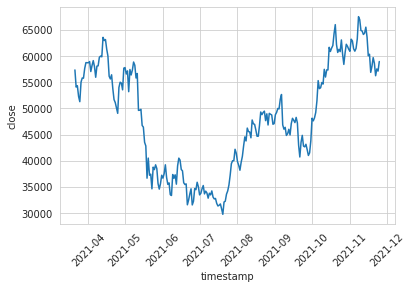

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
# basic visualization : price trend across the time
sns.lineplot(env.df_sample.index, env.df_sample.close)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

In [25]:
env.df_sample.index[0]

Timestamp('2021-04-17 00:00:00')

In [55]:
def get_position(action):
    if 0<=action<=4:
        return "long"
    elif action==5:
        return "clear"
    elif 5<action:
        return "short"

from leverage_trading_env import action2position

df_vis = env.df_sample[-len(actions):]
df_vis["action"] = np.array(actions)
df_vis["position"] = df_vis["action"].apply(get_position)
df_vis["timestamp"] = df_vis.index
df_vis["size"] = df_vis["action"].apply(lambda x: abs(action2position[x]))
df_vis.head()

/home/jeffrey/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/jeffrey/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/jeffrey/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,open,high,low,close,volume,action,position,timestamp,size
timestamp,,,,,,,,,
2021-10-26,63078.78,63293.48,59817.55,60328.81,40217.50083,5,clear,2021-10-26,0.0
2021-10-27,60328.81,61496.00,58000.00,58413.44,62124.49016,5,clear,2021-10-27,0.0
2021-10-28,58413.44,62499.00,57820.00,60575.89,61056.35301,5,clear,2021-10-28,0.0
2021-10-29,60575.90,62980.00,60174.81,62253.71,43973.90414,1,long,2021-10-29,0.4
2021-10-30,62253.70,62359.25,60673.00,61859.19,31478.12566,5,clear,2021-10-30,0.0


/home/jeffrey/anaconda3/envs/gpu/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


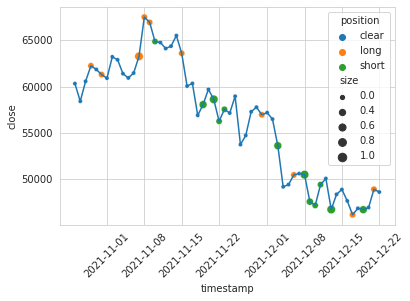

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.set_style('whitegrid')
sns.lineplot(df_vis.index, df_vis.close)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)


# sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.scatterplot(data=df_vis, x="timestamp", y="close", hue="position", size="size", markers="^")

fig.savefig("trade_visualization.png", dpi=300)